In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [4]:
## claims for provider_type internal medicine
q = """SELECT * FROM payments WHERE provider_type='Internal Medicine';"""
payments = pd.read_sql_query(q, con=con)

In [5]:
payments.shape

(1175625, 26)

In [26]:
## excluded npis of provider_type internal medicine (excl date > 2015-01-01)
fraud_npi = pd.read_csv("internal_medicine_npi_fraud.csv", dtype={'npi':str})
fraud_npi.shape

(44, 1)

In [27]:
fraud_npi.head()

,npi
0,1043238421
1,1043257744
2,1053458018
3,1073808945
4,1093851164


In [9]:
## number of drugs/non drug claims
payments.groupby(['hcpcs_drug_indicator'])['npi'].count()

hcpcs_drug_indicator
N    1076658
Y      98967
Name: npi, dtype: int64

In [10]:
## number of distinct hcpcs_codes claimed
len(payments.drop_duplicates('hcpcs_code'))

2260

In [14]:
## number of claims that were not performed in facility setting?
payments.groupby('place_of_service')['npi'].count()

place_of_service
F    409380
O    766245
Name: npi, dtype: int64

In [28]:
## fraudster place of service?
(payments.loc[payments['npi'].isin(list(fraud_npi['npi']))].
 groupby('place_of_service')['npi'].
 count())

place_of_service
F     83
O    444
Name: npi, dtype: int64

In [34]:
## how many fraudsters have 'O' place of service?
len(payments.loc[payments['npi'].isin(list(fraud_npi['npi']))].
   query('place_of_service == "O"').
   drop_duplicates('npi'))

42

In [36]:
## how many claims?
len(payments.loc[payments['npi'].isin(list(fraud_npi['npi']))].
   query('place_of_service == "O"'))

444

In [35]:
## how many fraudsters have 'F' place of service?
len(payments.loc[payments['npi'].isin(list(fraud_npi['npi']))].
   query('place_of_service == "F"').
   drop_duplicates('npi'))

17

## form feature vector for providers
features are hcpcs_codes{'O'/'F'} to take into account both in facility and out of facility claims.

Start simple by just considering place_of_service == 'O'.

In [31]:
by_npi = (payments.query('place_of_service == "O"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
          pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
          fillna(value=0))
by_npi.shape

(57331, 1877)

In [50]:
## color code for plotting
fraud_idx = by_npi.index.isin(list(fraud_npi['npi']))

## Visualize providers with with PCA components (centered, not scaled)

In [101]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

In [102]:
X_centered = preprocessing.scale(by_npi.as_matrix(), with_mean=True, with_std=False)

In [103]:
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)

In [104]:
svd.explained_variance_ratio_

array([ 0.36874722,  0.17766279,  0.11336691])

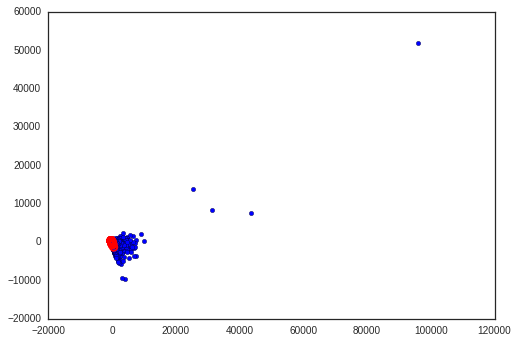

In [105]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

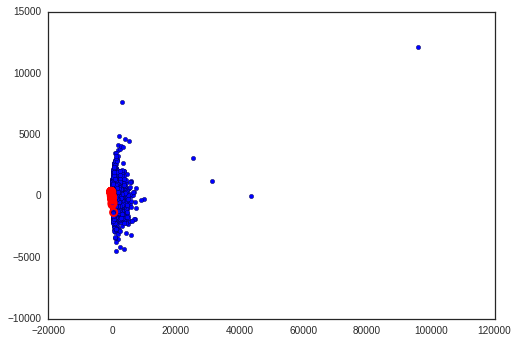

In [106]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

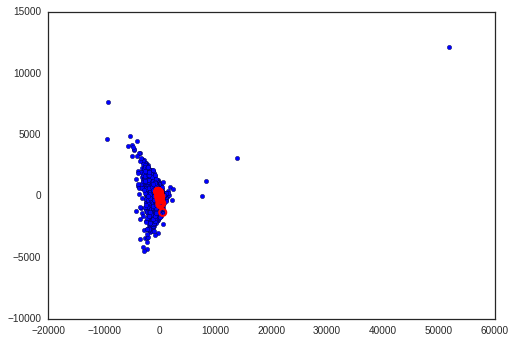

In [107]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

In [108]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
print(by_npi.columns.values[max_element_pc1])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pc1], 
             'hcpcs_description'].drop_duplicates())

80053


106    Blood test, comprehensive group of blood chemicals
Name: hcpcs_description, dtype: object

In [109]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
print(by_npi.columns.values[max_element_pc2])
pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pc2], 
             'hcpcs_description'].drop_duplicates())

99213


11    Established patient office or other outpatient visit, typically 15 minutes
Name: hcpcs_description, dtype: object

In [110]:
## locate the index of the largest absolute value in principle component 3
max_element_pc3 = np.argmax(np.absolute(svd.components_[2]))
print(by_npi.columns.values[max_element_pc3])
pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pc3], 
             'hcpcs_description'].drop_duplicates())

99214


12    Established patient office or other outpatient, visit typically 25 minutes
Name: hcpcs_description, dtype: object

### who are the providers with the top 4 largest scores on PC1?

In [111]:
provider_idxs = np.argsort(-X_reduced[:,0])[:4]
provider_idxs

array([56666, 12847, 33969, 16560])

In [112]:
X_reduced[provider_idxs, 0]

array([ 96019.619041  ,  43741.66251212,  31417.32234803,  25488.42403176])

In [113]:
by_npi.index[provider_idxs]

Index(['1982813028', '1225077134', '1598707200', '1285745612'], dtype='object', name='npi')

In [114]:
(payments[payments.npi.isin(by_npi.index[provider_idxs])].
 query('hcpcs_code == "80053"')[['npi','hcpcs_code','bene_day_srvc_cnt']])

,npi,hcpcs_code,bene_day_srvc_cnt
260822,1225077134,80053,18974.0
336440,1285745612,80053,23408.0
694120,1598707200,80053,13874.0
1161939,1982813028,80053,66101.0


In [115]:
payments.loc[payments.hcpcs_code=='80053',['npi','bene_day_srvc_cnt']].describe()

,bene_day_srvc_cnt
count,6662.000000
mean,376.799460
std,976.480893
min,11.000000
25%,91.000000
50%,251.000000
75%,495.750000
max,66101.000000


## Drop hcpcs codes for patient office visits (80053, 99213, 99214) and redo visual

In [116]:
X_centered = preprocessing.scale(by_npi.drop(['80053','99213','99214'], axis=1).
                                 as_matrix(), with_mean=True, with_std=False)

In [117]:
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced1 = svd.fit_transform(X_centered)

In [118]:
svd.explained_variance_ratio_

array([ 0.42729857,  0.12945489,  0.03921309])

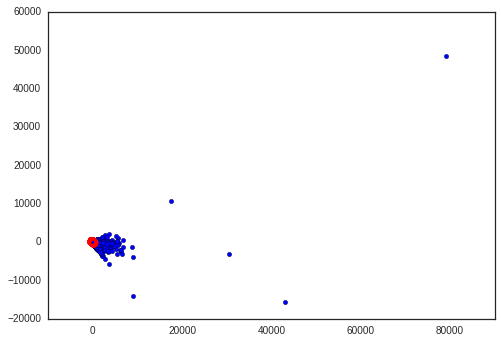

In [119]:
## pc1 & pc2
plt.scatter(X_reduced1[:,0], X_reduced1[:,1])
plt.scatter(X_reduced1[fraud_idx,0], X_reduced1[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

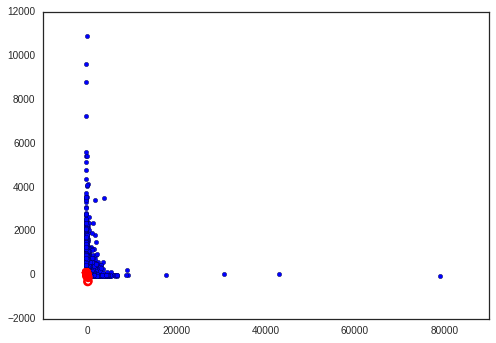

In [120]:
## pc1 & pc3
plt.scatter(X_reduced1[:,0], X_reduced1[:,2])
plt.scatter(X_reduced1[fraud_idx,0], X_reduced1[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

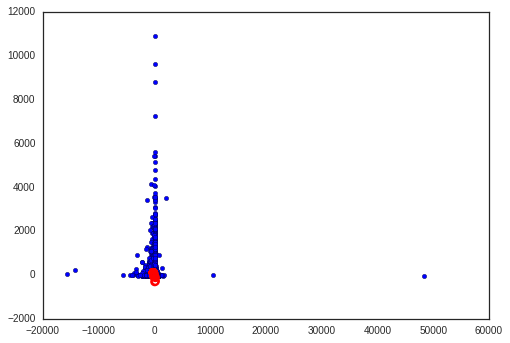

In [121]:
## pc2 & pc3
plt.scatter(X_reduced1[:,1], X_reduced1[:,2])
plt.scatter(X_reduced1[fraud_idx,0], X_reduced1[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

In [125]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
print(by_npi.columns.values[max_element_pc1])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.drop(['80053','99213','99214'], axis=1).columns.values[max_element_pc1], 
             'hcpcs_description'].drop_duplicates())

36415


17    Insertion of needle into vein for collection of blood sample
Name: hcpcs_description, dtype: object

In [126]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
print(by_npi.columns.values[max_element_pc2])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.drop(['80053','99213','99214'], axis=1).columns.values[max_element_pc2], 
             'hcpcs_description'].drop_duplicates())

36415


17    Insertion of needle into vein for collection of blood sample
Name: hcpcs_description, dtype: object

In [127]:
## locate the index of the largest absolute value in principle component 3
max_element_pc3 = np.argmax(np.absolute(svd.components_[2]))
print(by_npi.columns.values[max_element_pc3])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.drop(['80053','99213','99214'], axis=1).columns.values[max_element_pc3], 
             'hcpcs_description'].drop_duplicates())

99305


175    Subsequent nursing facility visit, typically 15 minutes per day
Name: hcpcs_description, dtype: object

## Drop 4 providers  with extreme counts

In [139]:
## providers to drop
by_npi.index[provider_idxs]

Index(['1982813028', '1225077134', '1598707200', '1285745612'], dtype='object', name='npi')

In [140]:
## redo fraud index
fraud_idx1 = (by_npi.drop(by_npi.index[provider_idxs]).index.
              isin(list(fraud_npi['npi'])))

In [141]:
X_centered = preprocessing.scale(by_npi.drop(by_npi.index[provider_idxs]).as_matrix(), with_mean=True, with_std=False)

In [142]:
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced2 = svd.fit_transform(X_centered)

In [143]:
svd.explained_variance_ratio_

array([ 0.33590058,  0.15951412,  0.11985491])

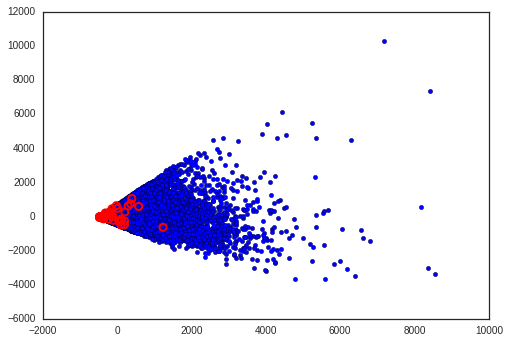

In [149]:
## pc1 & pc2
plt.scatter(X_reduced2[:,0], X_reduced2[:,1])
plt.scatter(X_reduced2[fraud_idx1,0], X_reduced2[fraud_idx1,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

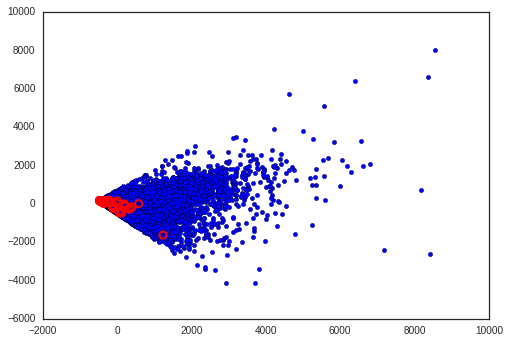

In [147]:
## pc1 & pc3
plt.scatter(X_reduced2[:,0], X_reduced2[:,2])
plt.scatter(X_reduced2[fraud_idx1,0], X_reduced2[fraud_idx1,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

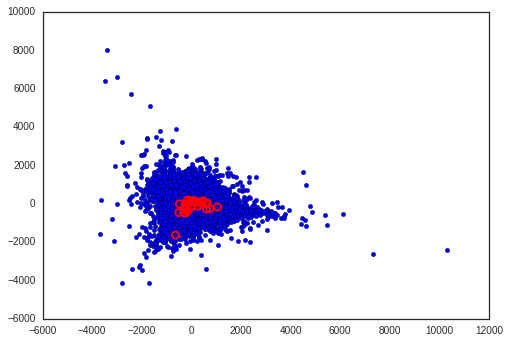

In [146]:
## pc2 & pc3
plt.scatter(X_reduced2[:,1], X_reduced2[:,2])
plt.scatter(X_reduced2[fraud_idx1,1], X_reduced2[fraud_idx1,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

## Drop 4 extreme providers, then standardize columns (center and scale)

In [150]:
## providers to drop
by_npi.index[provider_idxs]

Index(['1982813028', '1225077134', '1598707200', '1285745612'], dtype='object', name='npi')

In [151]:
X_centered = preprocessing.scale(by_npi.drop(by_npi.index[provider_idxs]).as_matrix(), with_mean=True, with_std=True)

In [152]:
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced3 = svd.fit_transform(X_centered)

In [153]:
svd.explained_variance_ratio_

array([ 0.01436722,  0.01166793,  0.01010523])

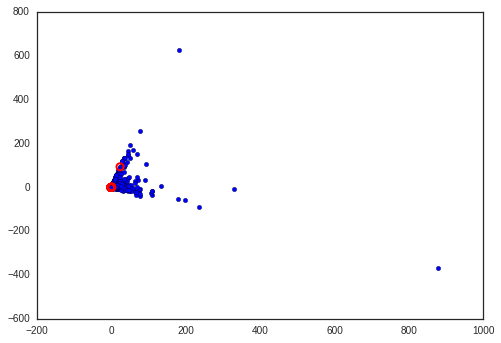

In [154]:
## pc1 & pc2
plt.scatter(X_reduced3[:,0], X_reduced3[:,1])
plt.scatter(X_reduced3[fraud_idx1,0], X_reduced3[fraud_idx1,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

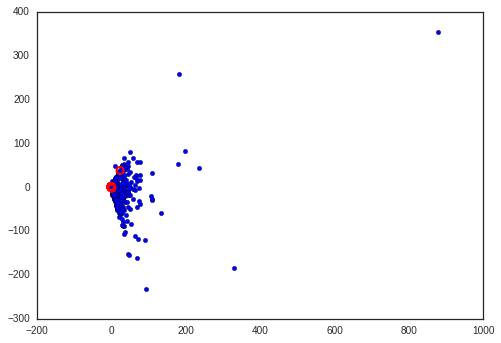

In [155]:
## pc1 & pc3
plt.scatter(X_reduced3[:,0], X_reduced3[:,2])
plt.scatter(X_reduced3[fraud_idx1,0], X_reduced3[fraud_idx1,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

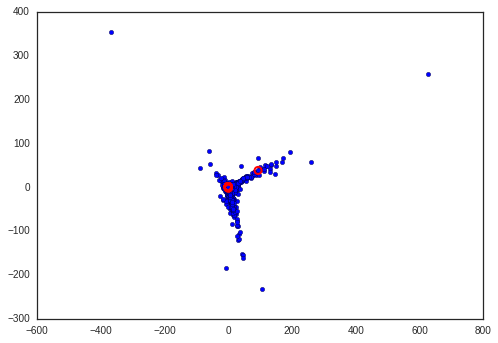

In [156]:
## pc2 & pc3
plt.scatter(X_reduced3[:,1], X_reduced3[:,2])
plt.scatter(X_reduced3[fraud_idx1,1], X_reduced3[fraud_idx1,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

## Try normalizing each provider's `bene_day_srvc_cnt` by `total_unique_benes` from the summary table

In [158]:
## claims for provider_type internal medicine
q = """SELECT npi, total_unique_benes FROM summary WHERE provider_type='Internal Medicine';"""
summary = pd.read_sql_query(q, con=con)

In [159]:
summary.head()

,npi,total_unique_benes
0,1003000126,913
1,1003000530,302
2,1003000936,958
3,1003002312,455
4,1003002379,162


In [165]:
## reorder summary rows to align with npi of by_npi rows
summary = (pd.DataFrame({'npi':by_npi.index}).merge(summary, sort=False))

In [170]:
by_npi_div_by_total = np.divide(by_npi.as_matrix().T, np.array(summary['total_unique_benes'])).T

In [171]:
X_centered = preprocessing.scale(by_npi_div_by_total, with_mean=True, with_std=False)

In [172]:
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced4 = svd.fit_transform(X_centered)

In [173]:
svd.explained_variance_ratio_

array([ 0.20846911,  0.19519815,  0.10183082])

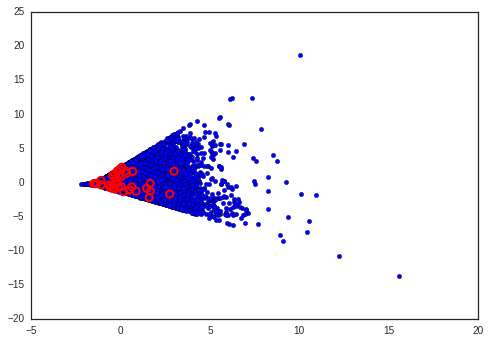

In [174]:
## pc1 & pc2
plt.scatter(X_reduced4[:,0], X_reduced4[:,1])
plt.scatter(X_reduced4[fraud_idx,0], X_reduced4[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

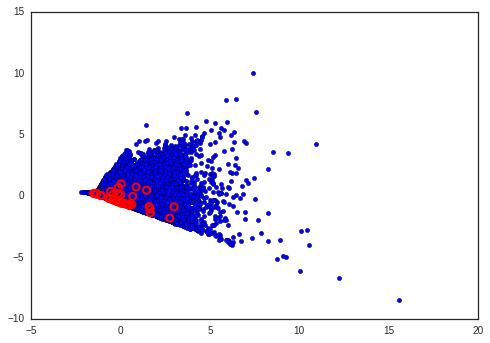

In [175]:
## pc1 & pc3
plt.scatter(X_reduced4[:,0], X_reduced4[:,2])
plt.scatter(X_reduced4[fraud_idx,0], X_reduced4[fraud_idx,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

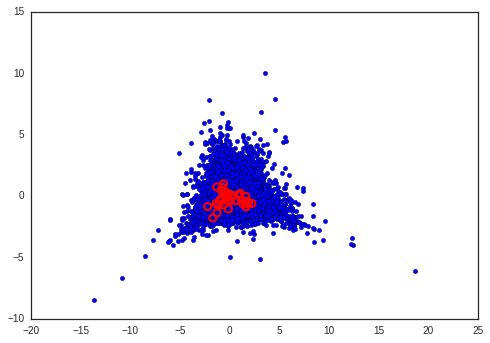

In [176]:
## pc2 & pc3
plt.scatter(X_reduced4[:,1], X_reduced4[:,2])
plt.scatter(X_reduced4[fraud_idx,1], X_reduced4[fraud_idx,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

In [177]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
print(by_npi.columns.values[max_element_pc1])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pc1], 
             'hcpcs_description'].drop_duplicates())

99214


12    Established patient office or other outpatient, visit typically 25 minutes
Name: hcpcs_description, dtype: object

In [182]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
print(by_npi.columns.values[max_element_pc2])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pc2], 
             'hcpcs_description'].drop_duplicates())

99213


11    Established patient office or other outpatient visit, typically 15 minutes
Name: hcpcs_description, dtype: object

In [181]:
## locate the index of the largest absolute value in principle component 3
max_element_pc3 = np.argmax(np.absolute(svd.components_[2]))
print(by_npi.columns.values[max_element_pc2])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pc2], 
             'hcpcs_description'].drop_duplicates())

36415


17    Insertion of needle into vein for collection of blood sample
Name: hcpcs_description, dtype: object

on PC1, fraudsters are clustered to the left, i.e. the fraction of claims that consist of patient visits of 25 minutes out of their total claims~total_unique_beneficiaries tends to be smaller than for non fraud doctors

## try plsda to tease out directions that may separate anomalies from regular group

In [183]:
from sklearn.cross_decomposition import PLSRegression

In [185]:
plsda = PLSRegression(n_components = 3, scale=False, max_iter=500, tol=1e-06, copy=True)

In [190]:
## X_centered from previous section is benef/total_unique_bene
X_pls, y_pls = plsda.fit_transform(X_centered, fraud_idx)

In [191]:
X_pls.shape

(57331, 3)

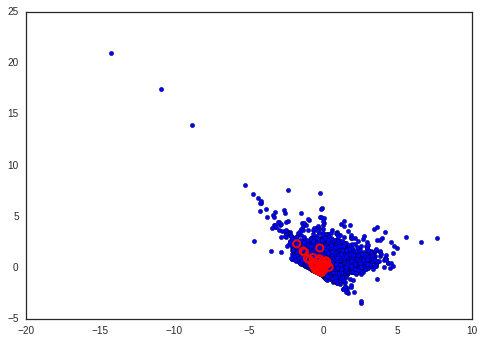

In [193]:
## pls components 1 and 2
plt.scatter(X_pls[:,0], X_pls[:,1])
plt.scatter(X_pls[fraud_idx,0], X_pls[fraud_idx,1], 
                facecolor='none', s=50, linewidths=2, edgecolors='r')

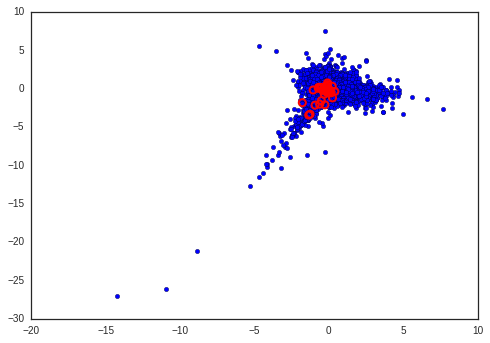

In [194]:
## pls components 1 and 3
plt.scatter(X_pls[:,0], X_pls[:,2])
plt.scatter(X_pls[fraud_idx,0], X_pls[fraud_idx,2], 
                facecolor='none', s=50, linewidths=2, edgecolors='r')

## plsda - drop 4 extreme providers, center and scale

In [197]:
plsda = PLSRegression(n_components = 3, scale=True, max_iter=500, tol=1e-06, copy=True)
X_pls, y_pls = plsda.fit_transform(by_npi.drop(by_npi.index[provider_idxs]).as_matrix(), fraud_idx1)

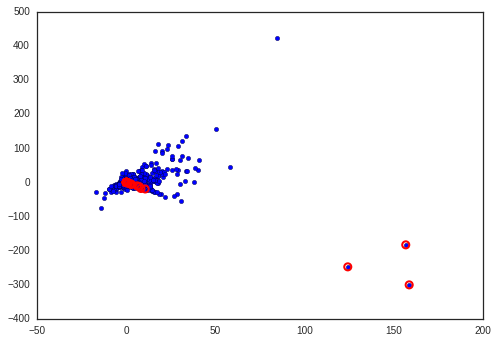

In [198]:
## pls components 1 and 2
plt.scatter(X_pls[:,0], X_pls[:,1])
plt.scatter(X_pls[fraud_idx1,0], X_pls[fraud_idx1,1], 
                facecolor='none', s=50, linewidths=2, edgecolors='r')

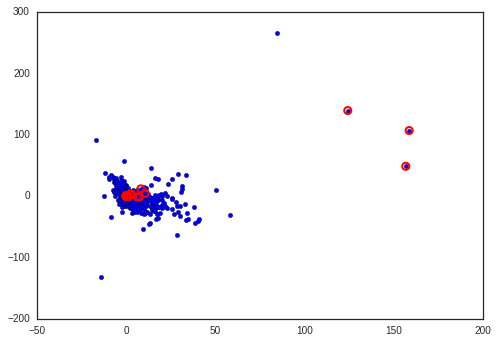

In [199]:
## pls components 1 and 3
plt.scatter(X_pls[:,0], X_pls[:,2])
plt.scatter(X_pls[fraud_idx1,0], X_pls[fraud_idx1,2], 
                facecolor='none', s=50, linewidths=2, edgecolors='r')

In [200]:
max_element_pls1 = np.argmax(np.absolute(plsda.x_weights_[0]))
print(by_npi.columns.values[max_element_pls1])

pd.set_option('max_colwidth', 80)
## which hcpcs_code does the max element correspond to?
(payments.loc[payments.hcpcs_code == by_npi.columns.values[max_element_pls1], 
             'hcpcs_description'].drop_duplicates())

00810


29851    Anesthesia for procedure on lower intestine using an endoscope
Name: hcpcs_description, dtype: object